# Importazione librerie

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import Metriche_di_performance as mdp
import dash
from dash import dcc, html
from dash.dependencies import Input, Output, State
from itertools import product

# Lettura dati Bitcoin

In [2]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [3]:
# Bull market
# data_inizio = '2020-12-01'
# data_fine = '2021-04-30'

# Mercato laterale
# data_inizio = '2022-07-01'
# data_fine = '2022-10-31'

# Bear market
# data_inizio = '2021-05-01'
# data_fine = '2021-07-31'

# Periodo personale
data_inizio = '2021-02-01'
data_fine = '2021-07-01'

indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2021-02-01,27790.582031
1,2021-02-02,29501.521484
2,2021-02-03,31119.447266
3,2021-02-04,30859.554688
4,2021-02-05,31658.248047
...,...,...
146,2021-06-27,29013.742188
147,2021-06-28,28866.302734
148,2021-06-29,30139.980469
149,2021-06-30,29555.054688


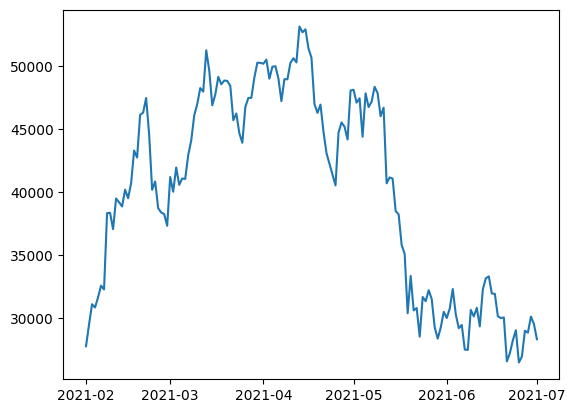

In [4]:
plt.plot(dati['Timestamp'], dati['Price'])

# Strategia

In [ ]:
# Funzioni di supporto
def aggiorna_trailing_stop(prezzo, prezzo_TS, perc_TS):
    return (1 - perc_TS) * prezzo + perc_TS * prezzo_TS

def quanto_acquistare(A_a, B_a, variazione_perc, perc_primo_acquisto, liquidità_attuale):
    if variazione_perc == 0:
        return liquidità_attuale * perc_primo_acquisto
    elif variazione_perc < 0:
        return liquidità_attuale * abs(variazione_perc) ** A_a / (B_a + (1 - B_a) * abs(variazione_perc) ** A_a)
    print('Errore! Non può essere maggiore di 0 la variazione tra un acquisto e il successivo')

def quanto_vendere(A_v, B_v, variazione_vendite_inversa, perc_prima_vendita, bitcoin):
    if variazione_vendite_inversa == 0:
        return bitcoin * perc_prima_vendita
    elif variazione_vendite_inversa < 0:
        return bitcoin * abs(variazione_vendite_inversa) ** A_v / (B_v + (1 - B_v) * abs(variazione_vendite_inversa) ** A_v)
    print('Errore! Non può essere maggiore di 0 la variazione inversa tra una vendita e la successiva')

In [ ]:
def trading_doppio_TS(
    dati, 
    liquidità_iniziale, 
    bitcoin_iniziali, 
    perc_primo_acquisto,
    perc_prima_vendita,
    perc_TS, 
    perc_TS_inverso_setting,
    A_a,
    B_a,
    A_v,
    B_v
):

    # Dati iniziali
    liquidità = liquidità_iniziale
    bitcoin = bitcoin_iniziali
    prezzo_TS = dati['Price'].iloc[0]
    prezzo_TS_inverso = dati['Price'].iloc[0]
    prezzo_minimo = dati['Price'].iloc[0]
    prezzo_max_ciclo = dati['Price'].iloc[0]

    # Variabili di supporto
    prezzo_medio_acquisti = 0  # Media pesata dei prezzi degli acquisti
    quantità_acquisti = 0  # Quantità totale di BTC acquistati nella scia attuale
    valore_totale_acquisti = 0  # Valore totale degli acquisti effettuati
    in_scia_acquisti = False  # Flag per controllare se siamo in una scia di acquisti
    ultima_azione = "-"
    flag = False
    n_vendite_ciclo = 0

    # Lista per registrare le transazioni
    transazioni = []

    # Itera sui dati
    for _, row in dati.iterrows():
        prezzo = row["Price"]
        timestamp = row["Timestamp"]
        azione = "-"
        liquidità_spesa_o_guadagnata = 0
        bitcoin_comprati_o_venduti = 0

        # Aggiorna il prezzo minimo nella scia corrente
        if in_scia_acquisti:
            if prezzo_minimo is None or prezzo < prezzo_minimo:
                prezzo_minimo = prezzo
                prezzo_TS_inverso = min(
                    prezzo * (1 + perc_TS_inverso_setting),
                    prezzo_medio_acquisti
                )

        # Controlla se l'acquisto è un "primo acquisto"
        if (ultima_azione == "Vendita" or ultima_azione == "-") and liquidità > 0:
            # Primo acquisto
            quantità_acquisto = perc_primo_acquisto * liquidità / prezzo
            liquidità_spesa_o_guadagnata = quantità_acquisto * prezzo
            liquidità -= liquidità_spesa_o_guadagnata
            bitcoin_comprati_o_venduti = quantità_acquisto
            bitcoin += bitcoin_comprati_o_venduti
            prezzo_medio_acquisti = prezzo
            valore_totale_acquisti = liquidità_spesa_o_guadagnata
            quantità_acquisti = quantità_acquisto
            prezzo_TS = prezzo_medio_acquisti * (1 + perc_TS)
            prezzo_minimo = prezzo
            prezzo_TS_inverso = min(prezzo_minimo * (1 + perc_TS_inverso_setting), prezzo_medio_acquisti) # in realtà al primo acquisto è ovvio che venga uguale a prezzo_medio_acquisti, quindi il calcolo del minimo è superfluo
            in_scia_acquisti = True
            ultima_azione = "Acquisto"
            azione = "Acquisto"
            prezzo_primo_acquisto = prezzo
            prezzo_precedente_acquisto = prezzo
            # n_acquisti_scia += 1
            n_vendite_ciclo = 0
            prezzo_max_ciclo = 0

        elif in_scia_acquisti and liquidità > 0:
            # Controlla se effettuare un acquisto in scia
            if prezzo < prezzo_medio_acquisti:
                if prezzo < prezzo_TS and prezzo >= prezzo_TS_inverso and prezzo < prezzo_precedente_acquisto: # direi che è superfluo chiedersi se prezzo < prezzo_TS perchè dovrebbe essere ovvio se prezzo < prezzo_medio_acquisti
                    # Acquisto in scia
                    variazione_acquisti = (prezzo - prezzo_primo_acquisto) / prezzo_primo_acquisto
                    quantità_acquisto = quanto_acquistare(A_a, B_a, variazione_acquisti, perc_primo_acquisto, liquidità) / prezzo
                    liquidità_spesa_o_guadagnata = quantità_acquisto * prezzo
                    liquidità -= liquidità_spesa_o_guadagnata
                    bitcoin_comprati_o_venduti = quantità_acquisto
                    bitcoin += bitcoin_comprati_o_venduti
                    valore_totale_acquisti += liquidità_spesa_o_guadagnata
                    quantità_acquisti += quantità_acquisto
                    prezzo_medio_acquisti = (prezzo_medio_acquisti * (valore_totale_acquisti - liquidità_spesa_o_guadagnata) + prezzo * liquidità_spesa_o_guadagnata) / valore_totale_acquisti
                    prezzo_TS = prezzo_medio_acquisti * (1 + perc_TS) # aggiorno prezzo_TS per aver acquistato
                    azione = "Acquisto"
                    prezzo_precedente_acquisto = prezzo
                    # n_acquisti_scia += 1

        # Controlla se effettuare una vendita
        if prezzo > prezzo_TS:
            if flag: # aggiorno prezzo_TS per aver superato prezzo_TS, ma solo se è appena successo
                prezzo_TS = aggiorna_trailing_stop(prezzo, prezzo_TS, perc_TS)
                flag = False
            if prezzo > prezzo_max_ciclo:
                prezzo_TS = aggiorna_trailing_stop(prezzo, prezzo_TS, perc_TS)
                prezzo_max_ciclo = prezzo
            else:
                pass
        elif prezzo < prezzo_TS and not flag: # se il prezzo è già salito oltre prezzo_TS e ora è tornato sotto quel livello
            # Vendita
            if n_vendite_ciclo == 0:
                prezzo_prima_vendita = prezzo
            variazione_vendite_inversa = (prezzo_prima_vendita - prezzo) / prezzo
            quantità_vendita = quanto_vendere(A_v, B_v, variazione_vendite_inversa, perc_prima_vendita, bitcoin)
            liquidità_spesa_o_guadagnata = quantità_vendita * prezzo
            liquidità += liquidità_spesa_o_guadagnata
            bitcoin_comprati_o_venduti = -quantità_vendita
            bitcoin += bitcoin_comprati_o_venduti
            azione = "Vendita"
            prezzo_TS = None
            prezzo_TS_inverso = None
            prezzo_minimo = None
            prezzo_medio_acquisti = 0
            quantità_acquisti = 0
            valore_totale_acquisti = 0
            in_scia_acquisti = False
            ultima_azione = "Vendita"
            flag = True
            n_vendite_ciclo += 1
            # n_acquisti_scia = 0

        # Valore totale del portafoglio
        valore_totale_portafoglio = liquidità + bitcoin * prezzo

        # Registra la transazione
        transazioni.append({
            "timestamp": timestamp,
            "prezzo": prezzo,
            "prezzo_medio_acquisti_scia": prezzo_medio_acquisti,
            "prezzo_TS": prezzo_TS,
            "prezzo_TS_inverso": prezzo_TS_inverso,
            "ultima_azione": ultima_azione,
            "azione": azione,
            "liquidità_spesa_o_guadagnata": liquidità_spesa_o_guadagnata,
            "bitcoin_comprati_o_venduti": bitcoin_comprati_o_venduti,
            "liquidità_posseduta": liquidità,
            "bitcoin_posseduti": bitcoin,
            "valore_totale_portafoglio": valore_totale_portafoglio,
        })

    # Converti la lista di transazioni in un dataframe
    df_transazioni = pd.DataFrame(transazioni)
    return df_transazioni

In [7]:
liquidità_iniziale=0
bitcoin_iniziali=0.02478146
perc_primo_acquisto=0.5
perc_prima_vendita=0.5
perc_TS=0.08
perc_TS_inverso_setting=0.05
A_a = 0.1
B_a = 0.15
A_v = 0.1
B_v = 0.15

df_transazioni = trading_doppio_TS(
    dati=dati,
    liquidità_iniziale=liquidità_iniziale,
    bitcoin_iniziali=bitcoin_iniziali,
    perc_primo_acquisto=perc_primo_acquisto,
    perc_prima_vendita=perc_prima_vendita,
    perc_TS=perc_TS,
    perc_TS_inverso_setting=perc_TS_inverso_setting,
    A_a = A_a,
    B_a = B_a,
    A_v = A_v,
    B_v = B_v
)

df_transazioni

,timestamp,prezzo,prezzo_medio_acquisti_scia,prezzo_TS,prezzo_TS_inverso,ultima_azione,azione,liquidità_spesa_o_guadagnata,bitcoin_comprati_o_venduti,liquidità_posseduta,bitcoin_posseduti,valore_totale_portafoglio
0,2021-02-01,27790.582031,0.000000,27790.582031,27790.582031,-,-,0.000000,0.000000,0.000000e+00,0.024781,688.691197
1,2021-02-02,29501.521484,0.000000,29364.646328,27790.582031,-,-,0.000000,0.000000,0.000000e+00,0.024781,731.090775
2,2021-02-03,31119.447266,0.000000,30979.063191,27790.582031,-,-,0.000000,0.000000,0.000000e+00,0.024781,771.185338
3,2021-02-04,30859.554688,0.000000,NaN,NaN,Vendita,Vendita,382.372410,-0.012391,3.823724e+02,0.012391,764.744820
4,2021-02-05,31658.248047,31658.248047,34190.907891,31658.248047,Acquisto,Acquisto,191.186205,0.006039,1.911862e+02,0.018430,774.641214
...,...,...,...,...,...,...,...,...,...,...,...,...
146,2021-06-27,29013.742188,48796.234797,52699.933581,27827.983887,Acquisto,-,0.000000,0.000000,1.911658e-14,0.022664,657.564370
147,2021-06-28,28866.302734,48796.234797,52699.933581,27827.983887,Acquisto,-,0.000000,0.000000,1.911658e-14,0.022664,654.222818
148,2021-06-29,30139.980469,48796.234797,52699.933581,27827.983887,Acquisto,-,0.000000,0.000000,1.911658e-14,0.022664,683.089315
149,2021-06-30,29555.054688,48796.234797,52699.933581,27827.983887,Acquisto,-,0.000000,0.000000,1.911658e-14,0.022664,669.832619


In [8]:
df_transazioni['valore_totale_portafoglio'].iloc[-1] / df_transazioni['valore_totale_portafoglio'].iloc[0]

np.float64(0.9326775190979973)

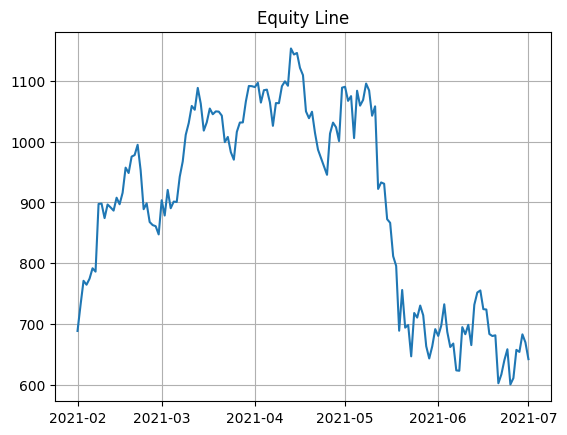

In [9]:
plt.title('Equity Line')
plt.grid()
plt.plot(df_transazioni['timestamp'], df_transazioni['valore_totale_portafoglio']);

In [10]:
mdp.calcola_principali_metriche(df_transazioni['valore_totale_portafoglio'], df_transazioni['prezzo'], df_transazioni['bitcoin_posseduti'])

{'Total Return': np.float64(-6.732248090200263),
 'Max Drawdown': 47.91722239688282,
 'Volatility': np.float64(0.6790766990696765),
 'Sharpe Ratio': np.float64(0.16791130374391197),
 'Sortino Ratio': np.float64(0.27991691252119477),
 'Calmar Ratio': np.float64(-0.1404974611098956),
 'Profit Factor': inf,
 'PnL': np.float64(72.95016448164705)}

In [11]:
df_transazioni[:50]

,timestamp,prezzo,prezzo_medio_acquisti_scia,prezzo_TS,prezzo_TS_inverso,ultima_azione,azione,liquidità_spesa_o_guadagnata,bitcoin_comprati_o_venduti,liquidità_posseduta,bitcoin_posseduti,valore_totale_portafoglio
0,2021-02-01,27790.582031,0.000000,27790.582031,27790.582031,-,-,0.000000,0.000000,0.000000,0.024781,688.691197
1,2021-02-02,29501.521484,0.000000,29364.646328,27790.582031,-,-,0.000000,0.000000,0.000000,0.024781,731.090775
2,2021-02-03,31119.447266,0.000000,30979.063191,27790.582031,-,-,0.000000,0.000000,0.000000,0.024781,771.185338
3,2021-02-04,30859.554688,0.000000,NaN,NaN,Vendita,Vendita,382.372410,-0.012391,382.372410,0.012391,764.744820
4,2021-02-05,31658.248047,31658.248047,34190.907891,31658.248047,Acquisto,Acquisto,191.186205,0.006039,191.186205,0.018430,774.641214
5,2021-02-06,32588.472656,31658.248047,34190.907891,31658.248047,Acquisto,-,0.000000,0.000000,191.186205,0.018430,791.785062
6,2021-02-07,32288.650391,31658.248047,34190.907891,31658.248047,Acquisto,-,0.000000,0.000000,191.186205,0.018430,786.259400
7,2021-02-08,38329.667969,31658.248047,38303.179904,31658.248047,Acquisto,-,0.000000,0.000000,191.186205,0.018430,897.594113
8,2021-02-09,38362.296875,31658.248047,38357.567517,31658.248047,Acquisto,-,0.000000,0.000000,191.186205,0.018430,898.195457
9,2021-02-10,37065.046875,0.000000,NaN,NaN,Vendita,Vendita,341.550600,-0.009215,532.736805,0.009215,874.287406


In [12]:
# Funzione per creare il grafico delle transazioni
def crea_grafico_transazioni(df_transazioni):
    # Gestione NaN per sicurezza
    df_transazioni['bitcoin_comprati_o_venduti'] = pd.to_numeric(df_transazioni['bitcoin_comprati_o_venduti'], errors='coerce')
    df_transazioni['liquidità_spesa_o_guadagnata'] = pd.to_numeric(df_transazioni['liquidità_spesa_o_guadagnata'], errors='coerce')

    # Filtra solo le transazioni di vendita e acquisto
    vendite = df_transazioni[df_transazioni['azione'] == 'Vendita']
    acquisti = df_transazioni[df_transazioni['azione'] == 'Acquisto']

    # Calcolo della dimensione dei punti per le vendite e gli acquisti
    max_quantita_vendita = vendite['bitcoin_comprati_o_venduti'].abs().max()
    max_quantita_acquisto = acquisti['liquidità_spesa_o_guadagnata'].max()

    def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
        return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

    # Applica la funzione di dimensione per ogni punto vendita e acquisto
    dimensioni_vendite = vendite['bitcoin_comprati_o_venduti'].abs().apply(lambda x: calcola_dimensione(x, max_quantita_vendita))
    dimensioni_acquisti = acquisti['liquidità_spesa_o_guadagnata'].apply(lambda x: calcola_dimensione(x, max_quantita_acquisto))

    # Funzione per creare una stringa di hover con tutte le colonne
    def crea_hover_text(df):
        hover_texts = []
        for _, row in df.iterrows():
            hover_text = "<br>".join([f"{col}: {row[col]}" for col in df.columns])
            hover_texts.append(hover_text)
        return hover_texts

    # Creazione del grafico
    fig = go.Figure()

    # Linea dell'andamento dei prezzi
    fig.add_trace(go.Scatter(
        x=df_transazioni['timestamp'],
        y=df_transazioni['prezzo'],
        mode='lines',
        name='Prezzi Bitcoin',
        line=dict(color='blue', width=2),
        hoverinfo='x+y'
    ))

    # Scatter plot per le vendite
    fig.add_trace(go.Scatter(
        x=vendite['timestamp'],
        y=vendite['prezzo'],
        mode='markers',
        name='Vendite',
        marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
        text=crea_hover_text(vendite),
        hoverinfo='text'
    ))

    # Scatter plot per gli acquisti
    fig.add_trace(go.Scatter(
        x=acquisti['timestamp'],
        y=acquisti['prezzo'],
        mode='markers',
        name='Acquisti',
        marker=dict(color='green', size=dimensioni_acquisti, opacity=0.7),
        text=crea_hover_text(acquisti),
        hoverinfo='text'
    ))

    # Configurazione del layout
    fig.update_layout(
        title='Andamento Prezzi Bitcoin, Transazioni di Vendita e Acquisto',
        xaxis_title='Data',
        yaxis_title='Prezzo (€)',
        hovermode='closest',
        template='plotly_white',
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        width=1200,
        height=800,
        xaxis=dict(
            rangeslider=dict(visible=True),  # Abilita il range slider
            type="date"  # Imposta l'asse x come asse temporale
        )
    )

    # Mostra il grafico
    fig.show()

In [13]:
crea_grafico_transazioni(df_transazioni)

### Grafico interattivo temporale

In [14]:
# Funzione per calcolare la dimensione dei pallini
def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
    return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

# Aggiungi colonne necessarie per dimensioni pallini
max_quantita_vendita = df_transazioni[df_transazioni['azione'] == 'Vendita']['liquidità_spesa_o_guadagnata'].max()
max_quantita_acquisto = df_transazioni[df_transazioni['azione'] == 'Acquisto']['liquidità_spesa_o_guadagnata'].max()

df_transazioni['dimensioni_vendite'] = df_transazioni.apply(
    lambda row: calcola_dimensione(row['liquidità_spesa_o_guadagnata'], max_quantita_vendita)
    if row['azione'] == 'Vendita' else 0, axis=1
)
df_transazioni['dimensioni_acquisti'] = df_transazioni.apply(
    lambda row: calcola_dimensione(row['liquidità_spesa_o_guadagnata'], max_quantita_acquisto)
    if row['azione'] == 'Acquisto' else 0, axis=1
)

# App Dash
app = dash.Dash(__name__)

# Layout Dash
app.layout = html.Div([
    html.H1("Grafico Interattivo delle Transazioni"),
    dcc.Graph(id='grafico-transazioni'),
    dcc.Slider(
        id='slider-giorno',
        min=0,
        max=len(df_transazioni) - 1,
        value=0,
        marks={i: str(df_transazioni['timestamp'].iloc[i].date()) for i in range(0, len(df_transazioni), 10)},
        step=1
    ),
    html.Div([
        html.Button("Giorno precedente", id='btn-prev', n_clicks=0),
        html.Button("Giorno successivo", id='btn-next', n_clicks=0),
    ], style={'marginTop': '20px', 'display': 'flex', 'gap': '10px'})
])

# Callback per aggiornare il grafico in base al giorno selezionato
@app.callback(
    Output('grafico-transazioni', 'figure'),
    Input('slider-giorno', 'value')
)
def aggiorna_grafico(giorno):
    # Filtra i dati fino al giorno corrente
    dati_fino_a_giorno = df_transazioni.iloc[:giorno + 1]
    dati_giorno_corrente = df_transazioni.iloc[giorno:giorno + 1]

    # Linea dei prezzi
    trace_prezzo = go.Scatter(
        x=dati_fino_a_giorno['timestamp'],
        y=dati_fino_a_giorno['prezzo'],
        mode='lines',
        name='Prezzi Bitcoin',
        line=dict(color='blue', width=2)
    )

    # Pallini per le vendite
    vendite = dati_fino_a_giorno[dati_fino_a_giorno['azione'] == 'Vendita']
    trace_vendite = go.Scatter(
        x=vendite['timestamp'],
        y=vendite['prezzo'],
        mode='markers',
        name='Vendite',
        marker=dict(color='red', size=vendite['dimensioni_vendite'], opacity=0.7)
    )

    # Pallini per gli acquisti
    acquisti = dati_fino_a_giorno[dati_fino_a_giorno['azione'] == 'Acquisto']
    trace_acquisti = go.Scatter(
        x=acquisti['timestamp'],
        y=acquisti['prezzo'],
        mode='markers',
        name='Acquisti',
        marker=dict(color='green', size=acquisti['dimensioni_acquisti'], opacity=0.7)
    )

    # Linea orizzontale per prezzo_TS del giorno corrente
    trace_TS = None
    if pd.notna(dati_giorno_corrente['prezzo_TS'].iloc[0]):
        trace_TS = go.Scatter(
            x=[dati_fino_a_giorno['timestamp'].min(), dati_fino_a_giorno['timestamp'].max()],
            y=[dati_giorno_corrente['prezzo_TS'].iloc[0]] * 2,
            mode='lines',
            name='Prezzo_TS',
            line=dict(color='purple', dash='dash')
        )

    # Linea orizzontale per prezzo_TS_inverso del giorno corrente
    trace_TS_inverso = None
    if pd.notna(dati_giorno_corrente['prezzo_TS_inverso'].iloc[0]):
        trace_TS_inverso = go.Scatter(
            x=[dati_fino_a_giorno['timestamp'].min(), dati_fino_a_giorno['timestamp'].max()],
            y=[dati_giorno_corrente['prezzo_TS_inverso'].iloc[0]] * 2,
            mode='lines',
            name='Prezzo_TS_inverso',
            line=dict(color='orange', dash='dash')
        )

    # Crea la figura
    figure = go.Figure(data=[trace_prezzo, trace_vendite, trace_acquisti])
    if trace_TS:
        figure.add_trace(trace_TS)
    if trace_TS_inverso:
        figure.add_trace(trace_TS_inverso)

    # Configurazione layout
    figure.update_layout(
        title='Grafico Interattivo delle Transazioni',
        xaxis_title=f"Date fino al {dati_giorno_corrente['timestamp'].iloc[0]}",
        yaxis_title='Prezzo (€)',
        hovermode='closest',
        template='plotly_white'
    )

    return figure

# Callback per gestire i pulsanti
@app.callback(
    Output('slider-giorno', 'value'),
    [Input('btn-prev', 'n_clicks'),
     Input('btn-next', 'n_clicks')],
    State('slider-giorno', 'value')
)
def aggiorna_slider(btn_prev, btn_next, slider_value):
    ctx = dash.callback_context

    if not ctx.triggered:
        return slider_value

    trigger_id = ctx.triggered[0]['prop_id'].split('.')[0]

    if trigger_id == 'btn-prev':
        return max(slider_value - 1, 0)
    elif trigger_id == 'btn-next':
        return min(slider_value + 1, len(df_transazioni) - 1)

    return slider_value

# Avvia l'app Dash
if __name__ == '__main__':
    app.run_server(debug=True)

# Grid search

In [15]:
def grid_search(param_grid, condizioni_salto, dati, liquidità_iniziale, bitcoin_iniziali):
    """
    Esegue una grid search sulla funzione strategia_vendita per ottimizzare i parametri variabili.
    
    Parameters:
    - param_grid (dict): Dizionario in cui le chiavi sono i nomi dei parametri e i valori sono liste di valori da testare.
    - dati (pd.DataFrame): DataFrame con i dati storici dei prezzi.
    - liquidità_iniziale (float): Liquidità iniziale in euro.
    - bitcoin_iniziali (float): Quantità iniziale di Bitcoin posseduti.
    
    Returns:
    - dict: Risultato con la miglior combinazione e il miglior fattore di rendimento.
    """
    # Genera tutte le combinazioni di parametri
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    all_combinations = list(product(*param_values))
    n_combinations = len(all_combinations)
    
    # Variabili per tracciare il miglior risultato
    miglior_fattore_rendimento = 0
    miglior_iterazione = None
    miglior_combinazione = None

    # Loop attraverso tutte le combinazioni
    for i, values in enumerate(all_combinations, start=1):
        # Crea un dizionario con la combinazione corrente di parametri
        params = dict(zip(param_names, values))
        
        if not condizioni_salto[i-1]:
            # Esegui la strategia con i parametri correnti
            df_transazioni = trading_doppio_TS(
                dati, liquidità_iniziale, bitcoin_iniziali, **params
            )

            # Calcola il fattore di rendimento
            portafoglio_finale = df_transazioni['valore_totale_portafoglio'].iloc[-1]
            portafoglio_iniziale = liquidità_iniziale + bitcoin_iniziali * dati['Price'].iloc[0]
            fattore_rendimento = portafoglio_finale / portafoglio_iniziale

            # Aggiorna il miglior risultato se il rendimento corrente è superiore
            if fattore_rendimento > miglior_fattore_rendimento:
                miglior_fattore_rendimento = fattore_rendimento
                miglior_iterazione = i
                miglior_combinazione = params

            # Stampa dei risultati dell'iterazione corrente
            print(f"Iterazione {i}/{n_combinations}")
            print(f"  Combinazione testata: {', '.join(f'{k}={v}' for k, v in params.items())}")
            print(f"  Fattore di rendimento: {fattore_rendimento:.4f}")
            print(f"  Miglior fattore di rendimento finora: {miglior_fattore_rendimento:.4f} "
                f"(Iterazione {miglior_iterazione}, Combinazione: {', '.join(f'{k}={v}' for k, v in miglior_combinazione.items())})")
            print("\n")
        else:
            print(f"Saltata combinazione {', '.join(f'{k}={v}' for k, v in params.items())} perchè sarebbe uguale a una già testata\n")

    # Ritorna il miglior risultato
    return {
        "miglior_fattore_rendimento": miglior_fattore_rendimento,
        "miglior_iterazione": miglior_iterazione,
        "miglior_combinazione": miglior_combinazione
    }

In [ ]:
# Esempio di definizione dei parametri per la grid search
param_grid = {
    "perc_primo_acquisto": [0.1, 0.5, 1],
    "perc_prima_vendita": [0.1, 0.5, 1],
    "perc_TS": [0, 0.02, 0.1],
    "perc_TS_inverso_setting": [0, 0.02, 0.1],
    "A_a": [0.01, 0.05, 2],
    "B_a": [0, 1, 5],
    "A_v": [0.01, 0.05, 2],
    "B_v":[0, 1, 5],
}

param_names = list(param_grid.keys())
param_values = list(param_grid.values())
all_combinations = list(product(*param_values))
n_combinations = len(all_combinations)

condizioni_salto = []
# Loop attraverso tutte le combinazioni
for i, values in enumerate(all_combinations, start=1):
    # Crea un dizionario con la combinazione corrente di parametri
    params = dict(zip(param_names, values))
    condizione = False
    condizioni_salto.append(condizione)

# Esecuzione della grid search
risultato = grid_search(param_grid, condizioni_salto, dati, liquidità_iniziale, bitcoin_iniziali)

# Stampa del miglior risultato
print("Risultato della Grid Search:")
print(f"  Miglior fattore di rendimento: {risultato['miglior_fattore_rendimento']}")
print(f"  Trovato all'iterazione: {risultato['miglior_iterazione']}")
print(f"  Combinazione di parametri ottimale: {', '.join(f'{k}={v}' for k, v in risultato['miglior_combinazione'].items())}")

# 1.6035

Iterazione 1/6561
  Combinazione testata: perc_primo_acquisto=0.1, perc_prima_vendita=0.1, perc_TS=0, perc_TS_inverso_setting=0, A_a=0.01, B_a=0, A_v=0.01, B_v=0
  Fattore di rendimento: 0.9916
  Miglior fattore di rendimento finora: 0.9916 (Iterazione 1, Combinazione: perc_primo_acquisto=0.1, perc_prima_vendita=0.1, perc_TS=0, perc_TS_inverso_setting=0, A_a=0.01, B_a=0, A_v=0.01, B_v=0)


Iterazione 2/6561
  Combinazione testata: perc_primo_acquisto=0.1, perc_prima_vendita=0.1, perc_TS=0, perc_TS_inverso_setting=0, A_a=0.01, B_a=0, A_v=0.01, B_v=1
  Fattore di rendimento: 0.9916
  Miglior fattore di rendimento finora: 0.9916 (Iterazione 1, Combinazione: perc_primo_acquisto=0.1, perc_prima_vendita=0.1, perc_TS=0, perc_TS_inverso_setting=0, A_a=0.01, B_a=0, A_v=0.01, B_v=0)


Iterazione 3/6561
  Combinazione testata: perc_primo_acquisto=0.1, perc_prima_vendita=0.1, perc_TS=0, perc_TS_inverso_setting=0, A_a=0.01, B_a=0, A_v=0.01, B_v=5
  Fattore di rendimento: 0.9916
  Miglior fattore di